In [1]:
%cd /home/skyworker/workspace/4dgs-slot-attention

/home/skyworker/workspace/4dgs-slot-attention


In [2]:
from utils import Logger

In [14]:
# %cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_04_21_gs_color_compete_RawColor
%cd /home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_05_11_temporal_obj_mean_rot_decoder_single_pe
!ls checkpoints/

/home/skyworker/result/4DGS_SlotAttention/slot_4dgs/movi_a_test_05_11_temporal_obj_mean_rot_decoder_single_pe
/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
0.ckpt	best_ari.ckpt  best_arifg.ckpt	best_loss.ckpt	last.ckpt


In [4]:
import matplotlib.pyplot as plt
from PIL import Image as Image

import torch
from omegaconf import OmegaConf
from model import SlotAttentionAutoEncoder
from dataset import ShapeOfMotion, collate_fn_padd
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Get cuda device
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

# Load YAML.
cfg = OmegaConf.load('config.yaml')

# Get CFG
seed = cfg.training.seed
batch_size = cfg.training.batch_size
num_slots = cfg.attention.num_slots
num_iters = cfg.attention.num_iters
resolution = tuple(cfg.dataset.resolution)

In [5]:

# Set target properties.
test_seq = 'movi_a_0000_anoMask'
cfg.attention.num_slots = 10
target_frame = 10

scene_path = os.path.join(cfg.dataset.dir, test_seq)
dataset = ShapeOfMotion(scene_path, cfg.dataset)
print(dataset[0].keys())
sample = dataset[0]
batch = collate_fn_padd([sample])

logger = Logger(batch,1,1,cfg,device)

dict_keys(['gt_render', 'gs', 'Ks', 'w2cs', 'ano'])


In [6]:
from renderer import Renderer

# Load ckpt
best_tag = 'arifg'
# ckpt = torch.load(os.path.join('checkpoints',f'best.ckpt'), map_location=device)
# print(f'Best : ', ckpt['epoch'])

ckpt = torch.load(os.path.join('checkpoints',f'best_{best_tag}.ckpt'), map_location=device)
print(f'Best {best_tag}: ', ckpt['epoch'])

# Load model.
model = SlotAttentionAutoEncoder(cfg.dataset, cfg.cnn, cfg.attention, batch['gs'].shape[-1])
model = model.to(device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

renderer = Renderer(resolution, 24, requires_grad=False)

image = batch['gt_render'].to(device)
gs = batch['gs'].to(device)
pad_mask = batch['mask'].to(device)
pe = batch['pe'].to(device)
Ks = batch['Ks'].to(device)
w2cs = batch['w2cs'].to(device)
ano = batch['ano'][0]
fg_mask:np.ndarray = ano != 0
fg_mask = fg_mask.squeeze(-1)

with torch.no_grad():
    # gs_recon, gs_slot, gs_mask, loss = model(gs, pe, pad_mask=pad_mask,isInference=True)
    gs_recon, gs_slot, gs_mask, loss = model(gs, pe, pad_mask=pad_mask)


Best arifg:  120


In [7]:
from matplotlib import animation
from IPython.display import HTML

# render_combined, render_slot, render_mask = renderer.make_vid(gs_recon, gs_slot, gs_mask, Ks, w2cs, render_rotate=True)
render_combined, render_slot = renderer.make_vid(gs[0], gs[0], gs_mask[0], Ks[0], w2cs[0], color_code=True)
render_combined = render_combined.cpu().detach().numpy()
vid = render_combined

dpi = 72
fig = plt.figure(figsize=(resolution[0]/dpi,resolution[1]/dpi), dpi=dpi)
im = plt.imshow(vid[0], interpolation='none')

plt.axis('off')  # turn off axis ticks and lines
plt.grid(False)  # disable grid
plt.tight_layout(pad=0)  # remove padding

def update(frame):
    im.set_data(vid[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(vid), interval=100)  # 100ms/frame
ani.save(f'render/{test_seq}_Recon_PLT_anim_{best_tag}.gif', writer='pillow', fps=10)

plt.close()  # Prevents duplicate plot
HTML(ani.to_jshtml())  # or ani.to_html5_video()


In [8]:
result, result_slots = logger.render_preview(gs_recon, gs_slot, gs_mask)
result = logger.make_vid_grid(result,2,3).cpu()
result_slots = logger.make_vid_grid(result_slots,5,2)
print(result.shape, result_slots.shape)
plt.imshow(result[target_frame].permute(1,2,0))

RuntimeError: shape '[20395, 24, 4]' is invalid for input of size 0

(24, 128, 128, 1)
0.8325495068370015


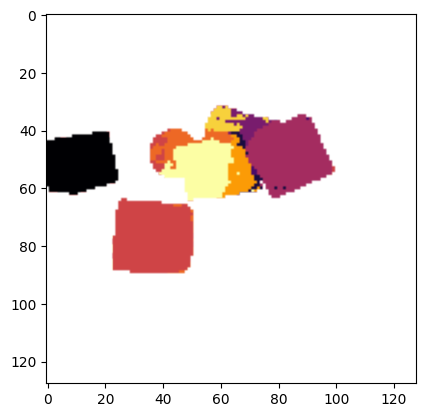

In [ ]:
from sklearn.metrics import adjusted_rand_score
render_mask = renderer.make_vid_slot(gs[0], gs_mask[0], Ks[0], w2cs[0], mask_as_color=True)
pred = render_mask.argmax(dim=1).cpu().numpy()
print(pred.shape)
plt.imshow(pred[target_frame], cmap='inferno',alpha=fg_mask[target_frame].astype(float))
pred_fg = pred[target_frame][fg_mask[target_frame]].flatten()
anos_fg = ano[target_frame][fg_mask[target_frame]].squeeze(-1).flatten()
arifg = adjusted_rand_score(anos_fg,pred_fg)
print(arifg)

In [ ]:
# from gsplat.distributed import cli
# from simple_viewer import viewer
# from argparse import Namespace
# slot_num = 1
# out_slot = gs_slot[0][slot_num]
# out_slot = out_slot[:,:14]
# out_slot[:,10] = gs_slot[0,slot_num,:,14]
# args = Namespace(
#     port=8080,
#     gs = out_slot.detach().cpu()
# )

# viewer(args)

In [ ]:
!tensorboard --logdir=logs

/bin/bash: /home/skyworker/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
